In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
!pwd
#modifica la rua
%cd "/content/gdrive/Shareddrives"

!ls
#modifica la ruta


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/Shareddrives
/content/gdrive/Shareddrives
'Exp. Quím. Eq. 4'
'IA avanzada'
'Modelación Matricial'
'Politica Mexicana'
'(S2) Equipo #3 - Análisis de Sistema eléctricos en sistemas ingenieriles'
'Sistemas Electromagnéticos'
'Team Company 1. Emprendimiento'
 Termoestadistica


In [ ]:
#LEER LOS DATASETS, CAMBIAR LOS NOMBRES DE LAS COLUMNAS Y CAMBIAS EL TIPO DE DATO EN COLUMNAS DE CABINA Y CLASE

#Se cambian los nombres de las columnas del DataFrame a fin de contar con un nombre más sencillo de interpretar. Además se cambió el tipo de dato para la columna Cabina y Clase
# a string para mantener concordancia con todos los datos que corresponen a Cabina y Clase, esto facilitará trabajar con ellos en un futuro.

train=pd.read_csv("/content/gdrive/Shareddrives/IA avanzada/Parte 1: Limpieza/train.csv")
test=pd.read_csv('/content/gdrive/Shareddrives/IA avanzada/Parte 1: Limpieza/test.csv')
gender=pd.read_csv('/content/gdrive/Shareddrives/IA avanzada/Parte 1: Limpieza/gender_submission.csv')
train.rename(columns={'SibSp':'Siblings/Spouses','Parch':'Parents/Children','Pclass':'Class','Fare':'Cost',
                      'PassengerId':'Id'},inplace=True)
train['Cabin']=train['Cabin'].astype(str)
train['Class']=train['Class'].astype(str)

In [ ]:
#CREAR FUNCIÓN PARA SEPARAR NOMBRE, APELLIDO Y TITULO
def Name_Last(row):
    data=row['Name']
    FullName=str.split(data,',')
    row['Last Name']=FullName[0]
    if '.' in FullName[-1]:
        Name=str.split(FullName[-1],'.')
        row['Name']=Name[-1]
        row['Title']=Name[0]
        return row
    else:
        row['Name']=FullName[-1]
        row['Title']=np.nan
        return row
train=train.apply(Name_Last,axis='columns')

In [ ]:
#CREAR UNA FUNCIÓN PARA SEPARAR LOS PARENTESIS DENTRO DE LOS NOMBRES Y SOLO DEJAR LOS NOMBRES
def Parentesis(row):
    Data=row['Name']
    pattern='\((.*)\)'
    Parentesis=re.findall(pattern,Data)
    if len(Parentesis)>=1:
        row['Parentesis']=Parentesis[0]
        Name=str.split(row['Name'],'(')
        row['Name']=Name[0]
        return row
    else:
        row['Parentesis']=np.nan
        return row
train=train.apply(Parentesis,axis='columns')

In [ ]:
#ESCOGER Y ORDENAR POR RELEVANCIA LAS COLUMNAS NECESARIAS DEL DATASET
train=train[['Id','Title','Name','Last Name','Sex','Age','Class','Cost','Cabin','Siblings/Spouses',
             'Parents/Children','Embarked','Survived']]

In [ ]:
#CREAR FUNCIÓN PARA DEVOLVER UNICAMENTE LA SECCIÓN DE LA CABINA Y REGRESAR '-' EN CASO DE NO TENER CABINA
def Cabin(row):
    pattern='[A-Z]'
    data=row['Cabin']
    if data=='nan':
        row['Cabin']='-'
        return row
    else:
        found=re.findall(pattern,data)
        row['Cabin']=found[0]
        return row
train=train.apply(Cabin,axis='columns')

In [ ]:
#CAMBIAR LOS DATOS DE LAS CLASES DE PASAJEROS POR UNA VARIABLE ORDINAL
def Class_Order(row):
    data=row['Class']
    if data=='1':
        row['Class']='First'
        return row
    elif data=='2':
        row['Class']='Second'
        return row
    elif data=='3':
        row['Class']='Third'
        return row
train=train.apply(Class_Order,axis='columns')

In [ ]:
#CAMBIAR LOS DATOS DEL PURTO DEL EMBARCAMIENTO POR SU NOMBRE COMPLETO

#Se realiza con la finalidad de tener la información completa de cada puerto a fin de evitar posibles confusiones futuras

def Port_Name(row):
    data=row['Embarked']
    if data=='C':
        row['Embarked']='Cherbourg'
        return row
    elif data=='Q':
        row['Embarked']='Queenstown'
        return row
    elif data=='S':
        row['Embarked']='Southampton'
        return row
    elif data!=data:
        row['Embarked']='-'
        return row
train=train.apply(Port_Name,axis='columns')

In [ ]:
#ESTABLECER UNA JERARQUIA DE LAS CLASES DE PASAJEROS
ordinal_Class=['Third','Second','First']
train['Class']=pd.Categorical(train['Class'],categories=ordinal_Class,ordered=True)

In [ ]:
#ESTABLECER UNA JERARQUIA DE LAS CLASES DE LAS CABINAS
ordinal_Cabin=['-','G','F','E','D','C','B','A']
train['Cabin']=pd.Categorical(train['Cabin'],categories=ordinal_Cabin,ordered=True)

In [ ]:
#CREAR UN DATAFRAME CON LAS EDADES MAXIMAS Y MINIMAS DE ACUERDO A LOS TTULOS EXISTENTES DE LOS PASAJEROS
#Promedio_Edades=train.groupby('Title').agg({'Age':(np.min,np.max,np.mean)})
#Promedio_Edades=Promedio_Edades.droplevel(0,axis=1)

In [ ]:
#CREAR UN DATAFRAME CON LAS EDADES MAXIMAS, MINIMAS, IQR, Q1,Q3, Lower bound y Upper bound
#DE ACUERDO A LOS TTULOS EXISTENTES DE LOS PASAJEROS
Min=[]
Max=[]
Mean=[]
IQR=[]
Last=[]
First=[]
Len=[]
Q1=[]
Q3=[]
for title in train['Title'].unique().tolist():
    df=train[train['Title']==title].dropna(subset='Age')
    minimo=np.min(df['Age'])
    maximo=np.max(df['Age'])
    media=np.mean(df['Age'])
    q1=np.percentile(df['Age'],25)
    q3=np.percentile(df['Age'],75)
    #Se ocuparon percentiles para establecer un rango donde se agrupen la mayoría de datos
    iqr=q3-q1
    last=q3+1.5*iqr
    first=q1-1.5*iqr
    NumTitle=len(df)
    Min.append(minimo)
    Max.append(maximo)
    Mean.append(media)
    IQR.append(iqr)
    Last.append(last)
    First.append(first)
    Len.append(NumTitle)
    Q1.append(q1)
    Q3.append(q3)
Ages_df=pd.DataFrame({'Title':train['Title'].unique().tolist(),'# Title':Len,
                     'Min':Min,'Max':Max,'Mean':Mean,'Q1':Q1,'Q3':Q3,'IQR':IQR,'Lower bound':First,'Upper bound':Last})
Ages_df.set_index('Title',inplace=True)

In [ ]:
#RELLENAR LOS VALORES FALTANTES DE LAS EDADES CON UN NUMERO RANDON DE ACUERDO AL DATAFRAME DE LAS EDADES MAXIMAS Y MINIMAS
#POR TITULO DEL PASAJERO

#Basandonos en la información del dataframe anterior Ages_pdf y ubicando el título
#que corresponde a la edad faltante en nuestro dataframe original,
#mediante un random que contiene el rango intercuartilico (lower bound y upper bound) como límites.
#Esto se hizo para que los datos del random de asignación se alejen de los datos atípicos, teniendo información
#que no se aleje de la realidad y para que nuestro modelo tenga pueda predecir de mejor manera.

def Edades_Faltantes(df,Promedio):
    Age=df.iloc[x]['Age']
    Title=df.iloc[x]['Title']
    if Age!=Age:

        if Promedio.loc[Title]['Min']>Promedio.loc[Title]['Lower bound']:
            minimo=Promedio.loc[Title]['Min']
        else:
            minimo=Promedio.loc[Title]['Lower bound']

        if Promedio.loc[Title]['Max']<Promedio.loc[Title]['Upper bound']:
            maximo=Promedio.loc[Title]['Max']
        else:
            maximo=Promedio.loc[Title]['Upper bound']

        Age=np.random.randint(minimo,maximo,1)[0]
        df.at[x,'Age']=Age
    return df

for x in range(0,len(train)):
    Edades_Faltantes(train,Ages_df)

In [ ]:
#DEFINIR UNA FUNCIÓN DE CLASIFICACIÓN DE ETAPA DE VIDA DEPENDIENDO DE LA EDAD
#Y AGREGAR UNA NUEVA COLUMNA LLAMADA AGE CLASIFICATION
def Clasificacion_Edad(row):
    data=row['Age']
    if data<18:
        row['Age Clasification']='Child'
        return row
    elif data<60:
        row['Age Clasification']='Adult'
        return row
    else:
        row['Age Clasification']='Old'
        return row
train=train.apply(Clasificacion_Edad,axis='columns')

In [ ]:
#DEFINIR UNA FUNCIÓN DE CLASIFICACIÓN DE CLASE SOCIAL DEPENDIENDO DEL DINERO PAGADO POR BOLETO
#Y AGREGAR UNA NUEVA COLUMNA LLAMADA SOCIAL CLASS

#Esto se utilizó para poder obervar de manera visual
#los sobrevivientes y no sobrevivientes respecto a la clasificación de
#clases sociales con base en el costo de su boleto

def Cost_Classification(df,variable):
    INFO=df[variable].describe()
    MIN=INFO.loc['min']
    q1=INFO.loc['25%']
    q3=INFO.loc['75%']
    IQR=q3-q1
    MAX=q3+1.5*IQR
    Clases=np.linspace(MIN,MAX,6)[1:]
    Social_clases=[]
    for x in range(0,len(df)):
        cost=df.iloc[x][variable]
        if cost<=Clases[0]:
            Social_clases.append('Baja-baja')
        elif cost<=Clases[1]:
            Social_clases.append('Baja-alta')
        elif cost<=Clases[2]:
            Social_clases.append('Media-baja')
        elif cost<=Clases[3]:
            Social_clases.append('Media-alta')
        elif cost<=Clases[4]:
            Social_clases.append('Alta-baja')
        else:
            Social_clases.append('Alta-alta')
    df['Social Classes']=Social_clases
    return df
train=Cost_Classification(train,'Cost')

In [ ]:
ordinal_SocialClass=['Baja-baja','Baja-alta','Media-baja','Media-alta','Alta-baja','Alta-alta']
train['Social Classes']=pd.Categorical(train['Social Classes'],categories=ordinal_SocialClass,ordered=True)

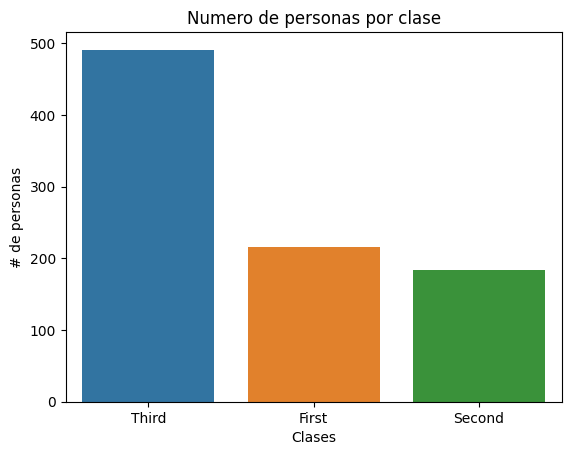

In [ ]:
#Se grafican el número de personas según su clase social. En el gráfico se muestra de forma significativa cómo la tercera clase tenían la mayor cantidad de personas a bordo siendo
#la segunda y la primera muy similares en proporción.
Classes=train['Class'].value_counts()
sns.barplot(x=Classes.index,y=Classes.values)
plt.xlabel('Clases')
plt.ylabel('# de personas')
plt.title('Numero de personas por clase')
plt.show()

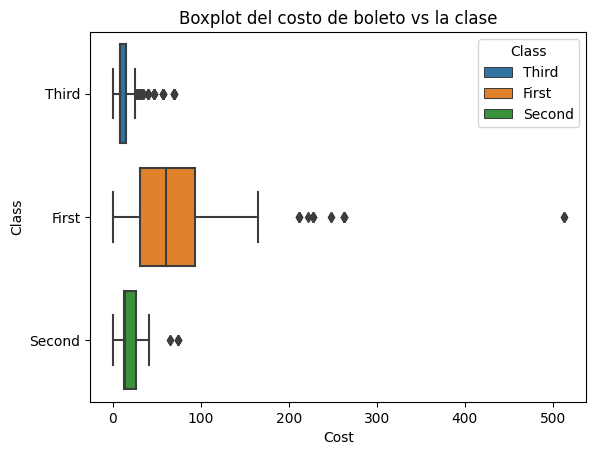

In [ ]:
#Se grafican la caja y bigote para visualizar la estadística general de las personas pertenecientes a una clase social y el costo del boleto.
#En la gráfica se observa los valores atípicos para cada clase (aquellos que salen del bigote), así como la media del costo del boleto para cada clase.
#En la primera clase se observa una variabilidad notable en los datos al tener bigotes más largos y datos atípicos más dispersos.
#Además, en la gráfica se observa que las medias del costo del boleto es comparable a la clae social a la que pertenecen.
sns.boxplot(data=train, x="Cost", y="Class",hue="Class", dodge=False)
plt.title('Boxplot del costo de boleto vs la clase')
plt.show()

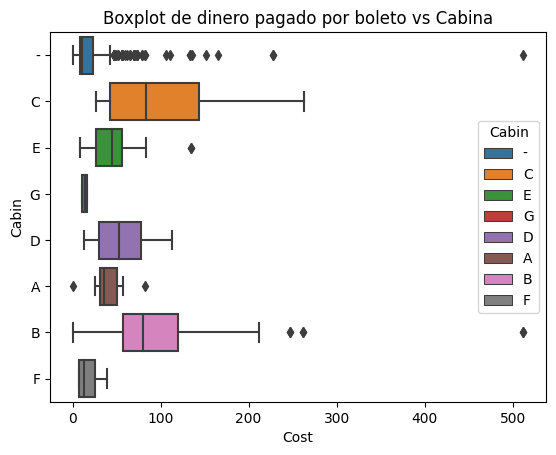

In [ ]:
#Se grafican la caja y bigote para visualizar la estadística general de las personas pertenecientes a una clase social y el costo del boleto.
#En la gráfica se observa los valores atípicos para cada clase (aquellos que salen del bigote), así como la media del costo del boleto para cada clase.
#En la primera clase se observa una variabilidad notable en los datos al tener bigotes más largos y datos atípicos más dispersos.

sns.boxplot(data=train, x="Cost", y="Cabin",hue="Cabin", dodge=False)
plt.title('Boxplot de dinero pagado por boleto vs Cabina')
plt.show()

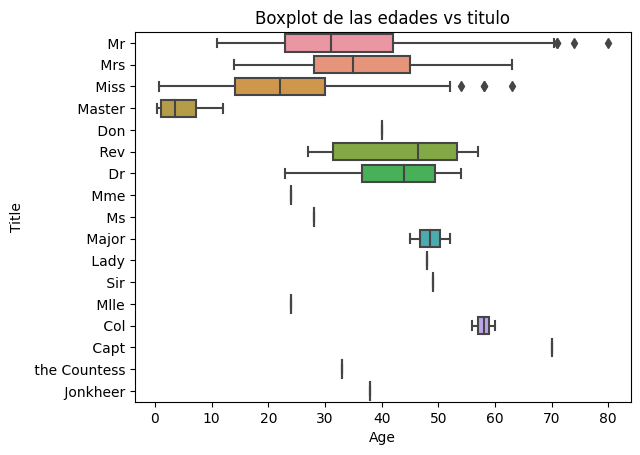

In [ ]:
#Se grafican la caja y bigote para visualizar la estadística general de las edades de las personas y el titulo asignado
#La importancia del gráfico reside en que se muestra una relación entre la edad y los títulos de las personas. Está relación se utilizó para predecir la edad de
#las personas que no contaban con un registro en la base de datos pero sí contaban con un titulo.

sns.boxplot(data=train,x='Age',y='Title',showfliers=True)
plt.title('Boxplot de las edades vs titulo')
plt.show()

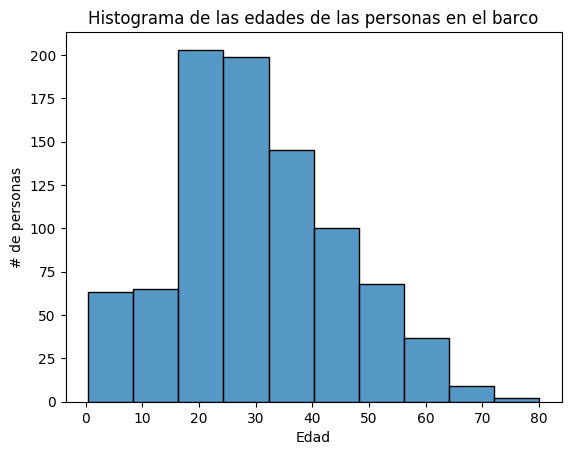

In [ ]:
#Se grafica la distribución de las personas según su edad. La particularidad de este gráfico es que arroja luz sobre la edad de las personas que más había en el barco, confirmando que
#había más jóvenes abordo siendo la edad que más frecuencia tiene entre 20 y 30 años.
#Este dato es relevante para determinar si una persona sobrevive o no pues, según la edad, las capacidades físicas y de salud se van limitando considerablemente.
sns.histplot(data=train,x='Age',bins=10)
plt.xlabel('Edad')
plt.ylabel('# de personas')
plt.title('Histograma de las edades de las personas en el barco')
plt.show()

In [ ]:
#FUNCIÓN PARA REALIZAR GRAFICAS DE BARRAS APILADAS CONSIDERANDO VIVOS Y MUERTOS POR CADA VARIABLE
def GraphVariable(df,variable):
    lista=df[variable].unique().tolist()
    vivos=[]
    muertos=[]
    for x in lista:
        DF=df[df[variable]==x]
        vivos.append(len(DF[DF['Survived']==1]))
        muertos.append(len(DF[DF['Survived']==0]))
    fig, ax = plt.subplots()
    ax.bar(lista,vivos,label='Vivos')
    ax.bar(lista,muertos, bottom = vivos,label='Muertos')
    plt.xlabel(variable)
    plt.ylabel('# de personas')
    plt.title('Vivos y Muertos vs '+variable)
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

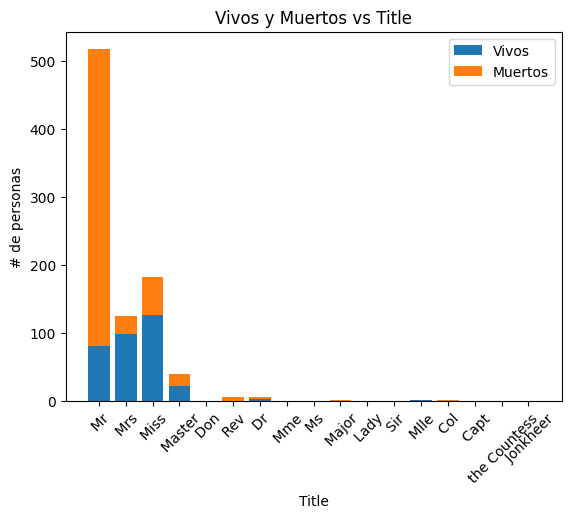

In [ ]:
#GRAFICA DE PERSONAS VIVAS Y MUERTAS VS SU TITULO ASIGNADO
#En la gráfica se muestra la proporción de personas vivas o muertas según su título. Se muestran diferentes tasas de supervivencia siendo las mujeres con el título Miss y
#Mrs las más contiene información importante pues, durante el naufragio, es muy probable que hubo prioridad de evacuación según su titulo por lo que puede existir una relación entre sexo y edad
#más profunda al analizar el título de las personas.

GraphVariable(train,'Title')

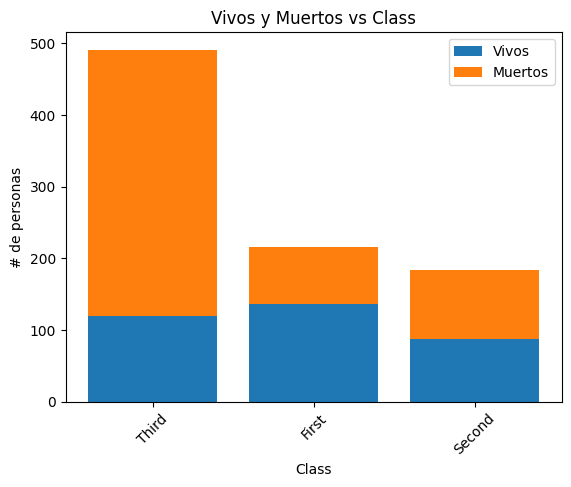

In [ ]:
#GRAFICA DE PERSONAS VIVAS Y MUERTAS VS SU CLASES ASIGNADA
#El gráfico muestra información relevante sobre la prioridad de evacuación según la clase social a la que pertenecían las personas, siendo la tasa de muertos más grande para
#personas de tercera clase. Considerando que la proporcion de personas que pertenecen a la tercera clase es mucho mayor que las demás, es interesante notar que mucho menos de la mitad
#de éstas se salvó, en cambio más de las mitad pertenecientes a la primera clase sí pudo salvarse y la mitad de las pertenecientes a la segunda también...)
GraphVariable(train,'Class')

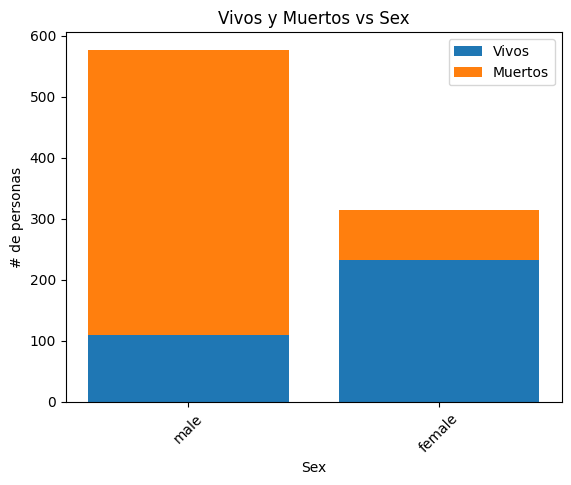

In [ ]:
#GRAFICA DE PERSONAS VIVAS Y MUERTAS VS SU SEXO
#El gráfico vuelve a recalca la importancia del sexo de las personas para predecir si la persona sobrevive o no. Esta importancia se hace evidente en el presente gráfico en el que
#se muestra la gran diferencia en la proporción de mujeres y hombres que sobrevivieron, siendo los últimos los que menos tasa de sobrevivencia tienen
GraphVariable(train,'Sex')

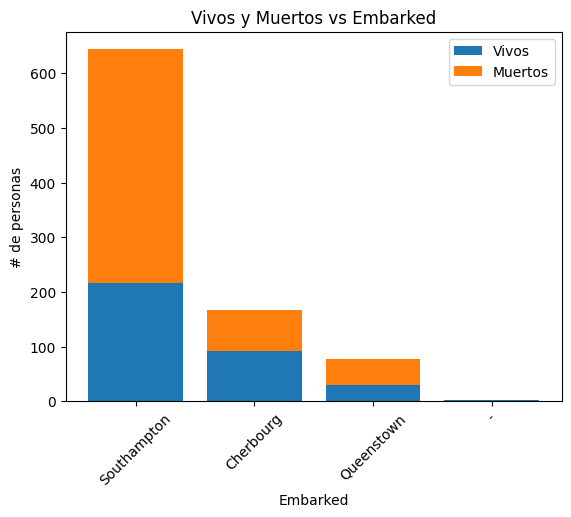

In [ ]:
#GRAFICA DE PERSONAS VIVAS Y MUERTAS VS SU EMBARCAMIENTO
#El gráfico nos remarca la cantidad de personas que se embarcaron  en los diferentes puertos y la cantidad de personas que fallecieron de esos sus respectivos puertos
#Con esto podemos analizar si el puerto puede tener un impacto en la supervivencia
GraphVariable(train,'Embarked')

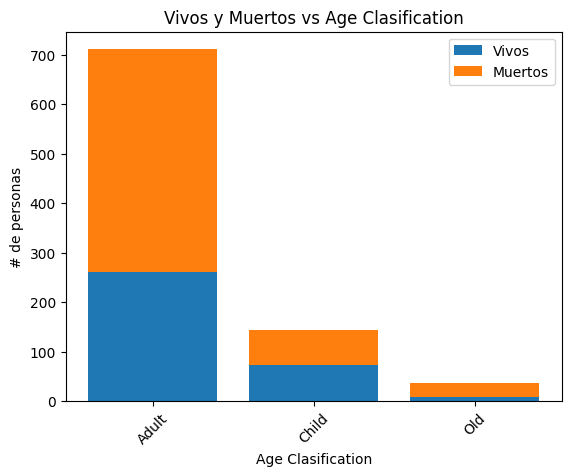

In [ ]:
#GRAFICA DE PERSONAS VIVAS Y MUERTAS VS SU EMBARCAMIENTO
#En estas tablas vemos ver los diferentes rangos de edad y su porcentaje de muerte
GraphVariable(train,'Age Clasification')

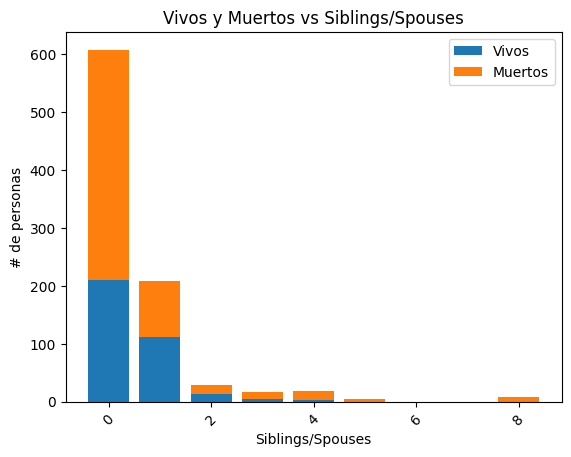

In [ ]:
#GRAFICA DE NUMERO DE PERSONAS VIVAS Y MUERTAS VS EL # DE HERMANOS O ESPOSAS QUE TENIAN DENTRO DEL TITANIC
#En esta grafica vemos el numero de las personas que sobrevivieron y murieron, teniendo 0 o mas hermanos o esposas
GraphVariable(train,'Siblings/Spouses')

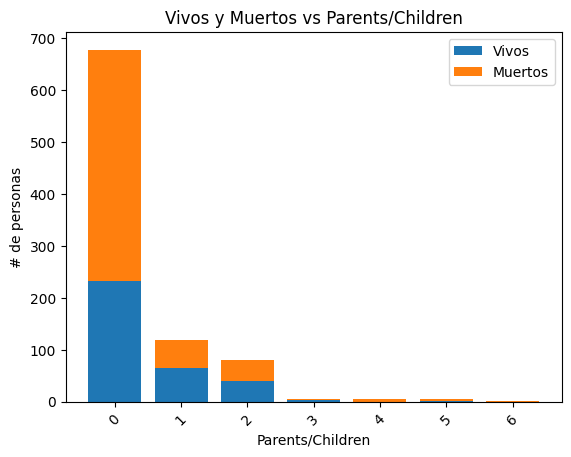

In [ ]:
#GRAFICA DE NUMERO DE PERSONAS VIVAS Y MUERTAS VS EL # DE PADRES O HIJOS QUE TENIAN DENTRO DEL TITANIC
#En esta grafica vemos el numero de las personas que sobrevivieron y murieron, teniendo 0 o mas hijos o padres dentro del titanic

GraphVariable(train,'Parents/Children')

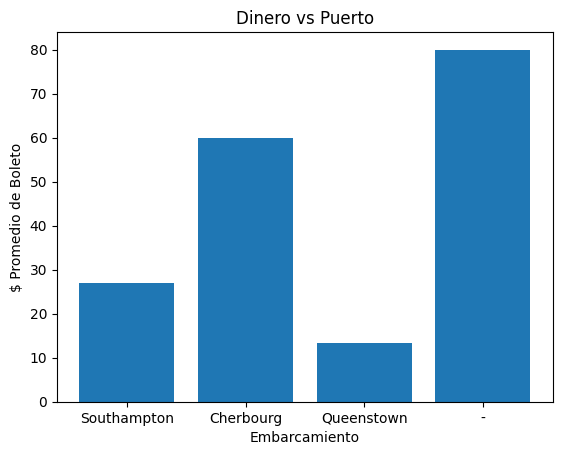

In [ ]:
#GRAFICA DEL DINERO PROMEDIOPOR BOLETO VS EL PUERTO DE EMBARCACIÓN

#En la siguiente grafica podemos ver lo que pagaron en promedio en cada puerto, esta informacion nos ayuda a saber si hay puertos mas caros que otros
Embarcamiento=train['Embarked'].unique().tolist()
Dinero_X_Embarcamiento=[]
for x in Embarcamiento:
    data=train[train['Embarked']==x]['Cost']
    Dinero_X_Embarcamiento.append(np.mean(data))
fig, ax = plt.subplots()
ax.bar(Embarcamiento, Dinero_X_Embarcamiento)
plt.xlabel('Embarcamiento')
plt.ylabel('$ Promedio de Boleto')
plt.title('Dinero vs Puerto')
plt.show()

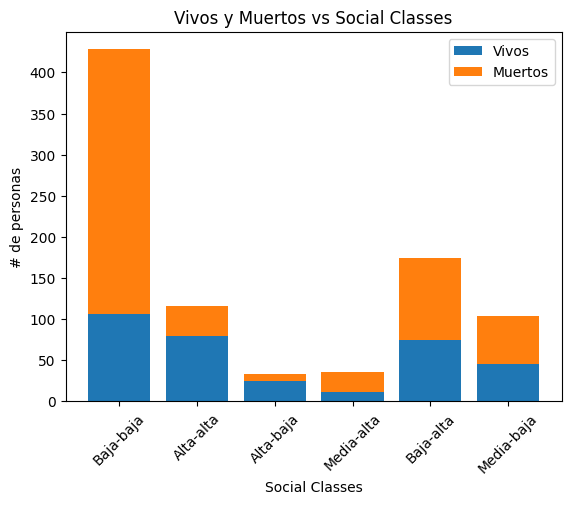

In [ ]:
GraphVariable(train,'Social Classes')
#La siguiente grafica nos ayuda a divisar el inicie de supervivencia de cada clase social